# Customer Segmentation and Analysis

This notebook aims at analyzing the content of an E-commerce database that lists purchases made by ∼4000 customers over a period of one year (from 2010/12/01 to 2011/12/09). Based on this analysis, I develop a model that allows to anticipate the purchases that will be made by a new customer, during the following year and this, from its first purchase.

### Steps to solve the problem :
1- Importing Libraries.<br>
2- Exploration of data.<br>
3- Data Visualization.<br>
4- Clustering using K-Means.<br>
5- Selection of Clusters.<br>
6- Ploting the Cluster Boundry and Clusters.<br>
7- 3D Plot of Clusters.<br>

### 1- Importing Libraries.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
from sklearn.cluster import KMeans
import warnings
import os
warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)
#print(os.listdir("../input"))

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/rfm-metrix/rfm metrics.png
/kaggle/input/ecommerce-data/data.csv


In [3]:
df = pd.read_csv(r'../input/ecommerce-data/data.csv',encoding="ISO-8859-1",
                dtype={'CustomerID': str,'InvoiceID': str})
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


## 2. Perform EDA (Exploratory Data Analysis) - Understanding the Datasets :
### 2.1 Explore data and get to know what each Column / Feature denotes :

In [4]:
# 1 : Displays Data Information :

def display_data_information(data, data_types, dataframe_name):
    print(" Information of ",dataframe_name,": Rows = ",data.shape[0],"| Columns = ",data.shape[1],"\n")
    data.info()
    print("\n")
    for VARIABLE in data_types :
        data_type = data.select_dtypes(include=[ VARIABLE ]).dtypes
        if len(data_type) > 0 :
            print(str(len(data_type))+" "+VARIABLE+" Features\n"+str(data_type)+"\n"  )        

# Display Data Information of "train" :

data_types  = ["float32","float64","int32","int64","object","category","datetime64[ns]"]
display_data_information(df, data_types, "train")

 Information of  train : Rows =  541909 | Columns =  8 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


1 float64 Features
UnitPrice    float64
dtype: object

1 int64 Features
Quantity    int64
dtype: object

6 object Features
InvoiceNo      object
StockCode      object
Description    object
InvoiceDate    object
CustomerID     object
Country        object
dtype: object



In [5]:
# 2 : Displays Data Head (Top Rows) and Tail (Bottom Rows) of the Dataframe (Table) :

def display_head_tail(data, head_rows, tail_rows):
    display("Data Head & Tail :")
    display(data.head(head_rows).append(data.tail(tail_rows)))
#     return True

# Displays Data Head (Top Rows) and Tail (Bottom Rows) of the Dataframe (Table)
# Pass Dataframe as "train", No. of Rows in Head = 3 and No. of Rows in Tail = 2 :

display_head_tail(df, head_rows=3, tail_rows=2)

'Data Head & Tail :'

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680,France


In [6]:
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,object,float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0.0,0.0,0.268311,0.0,0.0,0.0,24.926694,0.0


While looking at the number of null values in the dataframe, it is interesting to note that  `∼ 25% `of the entries are not assigned to a particular customer. With the data available, it is impossible to impute values for the user and these entries are thus useless for the current exercise. So i will `delete` them from the dataframe:

In [7]:
df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df.shape)
#____________________________________________________________
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,object,float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df.describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


### 2.2 Fill/Impute Missing Values Continuous - Mean/Median/Any Specific Value & Categorical - Others/ForwardFill/BackFill :

In [9]:
# # Python Method 5 : Fills or Imputes Missing values with Various Methods : 

# def fill_missing_values(data, fill_value, fill_types, columns, dataframe_name):
    
#     print("Missing Values BEFORE REMOVAL in ",dataframe_name," data")
#     display(data.isnull().sum())
#     for column in columns :
        
#         # Fill Missing Values with Specific Value :
#         if "Value_Fill" in fill_types :
#             data[ column ] = data[ column ].fillna(fill_value)
# #             print("Value_Fill")

#         # Fill Missing Values with Forward Fill  (Previous Row Value as Current Row in Table) :
#         if "Forward_Fill" in fill_types :
#             data[ column ] = data[ column ].ffill(axis = 0)
# #             print("Forward_Fill")

#         # Fill Missing Values with Backward Fill (Next Row Value as Current Row in Table) :
#         if "Backward_Fill" in fill_types :
#             data[ column ] = data[ column ].bfill(axis = 0)
# #             print("Backward_Fill")
    
#     print("Missing Values AFTER REMOVAL in ",dataframe_name," data")
#     display(data.isnull().sum())
    
#     return data

# fill_types = [ "Forward_Fill"]
# fill_value = 0
# # Fills or Imputes Missing values in "Registration_Date" Column with "Forward_Fill" Method in "train" : 
# train = fill_missing_values(train, fill_value, fill_types, ["Registration_Date"],"train")

# # Fills or Imputes Missing values in "Registration_Date" Column with "Forward_Fill" Method in "train" :
# test  = fill_missing_values(test, fill_value, fill_types, ["Registration_Date"],"test")

OK, therefore, by removing these entries we end up with a dataframe filled at 100% for all variables! Finally, I check for duplicate entries and delete them:

### 2.3. Remove Duplicate Rows from Train data if present 

In [10]:
# Python Method 4 : Removes Data Duplicates while Retaining the First one - Similar to SQL DISTINCT :
print('Duplicate entries: {}'.format(df.duplicated().sum()))
df.drop_duplicates(inplace = True)

def remove_duplicate(data):
    
    print("BEFORE REMOVING DUPLICATES - No. of Rows = ",data.shape[0])
    data.drop_duplicates(keep="first", inplace=True) 
    print("AFTER REMOVING DUPLICATES  - No. of Rows = ",data.shape[0])
    
    return data

# Remove Duplicates from "train" data :

train = remove_duplicate(df)

# No Duplicates at all !!!

Duplicate entries: 5225
BEFORE REMOVING DUPLICATES - No. of Rows =  401604
AFTER REMOVING DUPLICATES  - No. of Rows =  401604



#### 2. Exploring the content of variables
This dataframe contains 8 variables that correspond to:

**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.<br>
**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.<br>
**Description**: Product (item) name. Nominal.<br>
**Quantity**: The quantities of each product (item) per transaction. Numeric.<br>
**InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated.<br>
**UnitPrice**: Unit price. Numeric, Product price per unit in sterling.<br>
**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.<br>
**Country**: Country name. Nominal, the name of the country where each customer resides<br>

In [11]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

#### 2.1 Countries ,Customers and products

Display Number of customers per each country using `go.figure plotly`

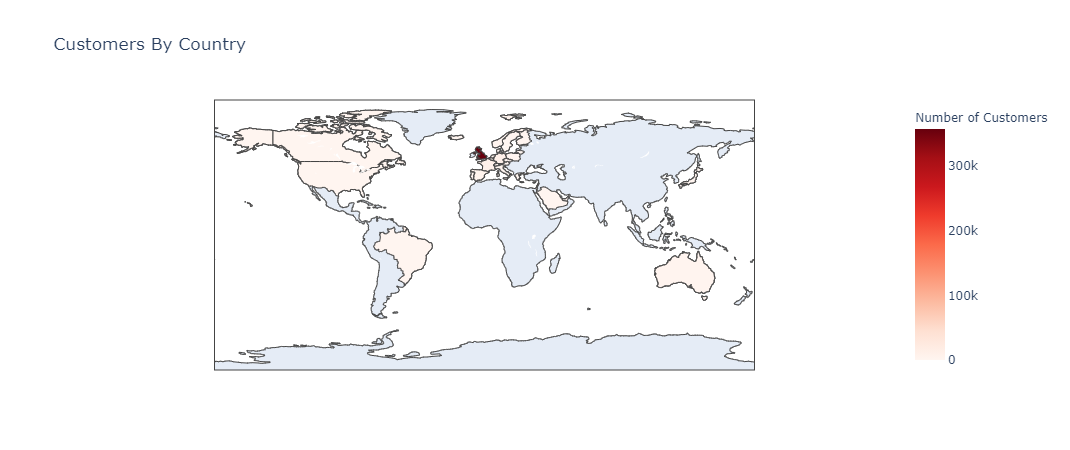

In [12]:
import plotly_express as px
import plotly.graph_objects as go
df_country = pd.DataFrame(df['Country'].value_counts()).reset_index()
df_country.rename(columns = {'index':'Country', 'Country':'count'}, inplace=True)

fig = go.Figure(data=go.Choropleth(
    locations=df_country['Country'], # Spatial coordinates
    z = df_country['count'].astype(float), # Data to be color-coded
    locationmode = 'country names', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Number of Customers",
))

fig.update_layout(
    title_text = 'Customers By Country',
    geo_scope='world', # limite map scope to USA
)

fig.show()

In [13]:
print("Number of Categories in: ")
for ColName in df[['Country','StockCode','InvoiceNo','CustomerID']]:
    print("{} = {}".format(ColName,len(df[ColName].unique())))

Number of Categories in: 
Country = 37
StockCode = 3684
InvoiceNo = 22190
CustomerID = 4372


It can be seen that the data concern `4372` users and that they bought `3684` different products.<br> The total number of transactions carried out is of the order of  ∼ `22'000`.

Now I will determine the number of products purchased in every transaction:

In [14]:
tab1=df.groupby(['CustomerID',"InvoiceNo"],as_index=False).agg({'StockCode': ['count']})
products_per_basket=tab1.rename(columns ={'StockCode':'product'})
products_per_basket.head(10)

,CustomerID,InvoiceNo,product
,,,count
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11


The first lines of this list shows several things worthy of interest:<br>

* The existence of entries with the prefix `C` for the **InvoiceNo** variable: this indicates transactions that have been canceled<br>
* The existence of users who only came once and only purchased one product (e.g. nº12346)<br>
* The existence of frequent users that buy a large number of items at each order

#### 2.1.2 Cancelling orders
First of all, I count the number of transactions corresponding to canceled orders:

In [15]:
products_per_basket['order_canceled'] = products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(products_per_basket.head(10))
n1 = products_per_basket['order_canceled'].sum()
n2 = products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))


,CustomerID,InvoiceNo,product,order_canceled
,,,count,
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0
5,12347,556201,18,0
6,12347,562032,22,0
7,12347,573511,47,0
8,12347,581180,11,0


Number of orders canceled: 3654/22190 (16.47%) 


We note that the number of cancellations is quite large ( ∼ 16% of the total number of transactions). Now, let's look at the first lines of the dataframe:

In [16]:
df.sort_values('CustomerID').head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland
14944,537626,22773,GREEN DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland
14945,537626,22774,RED DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland
14946,537626,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland
14947,537626,22805,BLUE DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland
148285,549222,22376,AIRLINE BAG VINTAGE JET SET WHITE,4,2011-04-07 10:43:00,4.25,12347,Iceland


On these few lines, we see that when an order is canceled, we have another transactions in the dataframe, mostly identical except for the **Quantity** and **InvoiceDate** variables. I decide to check if this is true for all the entries. To do this, I decide to locate the entries that indicate a `negative` quantity and check if there is systematically an order indicating the same quantity (but positive), with the same description (**CustomerID, Description and UnitPrice**):

In [17]:
df_check = df[df['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
display(df_check.head(13))
for index, col in  df_check.iterrows():
    if df[(df['CustomerID'] == col[0]) & (df['Quantity']==-col[1]) &
          (df['Description']==col[3])].shape[0] == 0:
        print(df_check.loc[index])
        print(10*'-'+'>'+' HYPOTHESIS NOT FULFILLED','<',10*'-')
        break
    

,CustomerID,Quantity,StockCode,Description,UnitPrice
141,14527,-1,D,Discount,27.50
154,15311,-1,35004C,SET OF 3 COLOURED FLYING DUCKS,4.65
235,17548,-12,22556,PLASTERS IN TIN CIRCUS PARADE,1.65
236,17548,-24,21984,PACK OF 12 PINK PAISLEY TISSUES,0.29
237,17548,-24,21983,PACK OF 12 BLUE PAISLEY TISSUES,0.29
238,17548,-24,21980,PACK OF 12 RED RETROSPOT TISSUES,0.29
239,17548,-12,21484,CHICK GREY HOT WATER BOTTLE,3.45
240,17548,-12,22557,PLASTERS IN TIN VINTAGE PAISLEY,1.65
241,17548,-24,22553,PLASTERS IN TIN SKULLS,1.65
939,17897,-6,22960,JAM MAKING SET WITH JARS,4.25


CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
----------> HYPOTHESIS NOT FULFILLED < ----------


#### 2.2.2 StockCode<br>

Above, it has been seen that some values of the **StockCode** variable indicate a particular transaction (i.e. `D` for `Discount`). I check the contents of this variable by looking for the set of codes that would contain only letters:

In [18]:
list_special_codes = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [19]:
for code in list_special_codes:
    print(code, 10*'-'+'>',df[df['StockCode'] == code]['Description'].unique())

POST ----------> ['POSTAGE']
D ----------> ['Discount']
C2 ----------> ['CARRIAGE']
M ----------> ['Manual']
BANK CHARGES ----------> ['Bank Charges']
PADS ----------> ['PADS TO MATCH ALL CUSHIONS']
DOT ----------> ['DOTCOM POSTAGE']
CRUK ----------> ['CRUK Commission']


We see that there are several types of peculiar transactions, connected e.g. to port charges or bank charges.

#### 2.2.3 Basket Price

In [20]:
df['TotalPrice']=df['Quantity']*df['UnitPrice']
df.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom,-77183.6
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland,17.0
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland,13.2
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland,15.0


Each entry of the dataframe indicates prizes for a single kind of product. Hence, orders are split on several lines. I collect all the purchases made during a single order to recover the total order prize:

In [21]:
tab2=df.groupby(['CustomerID',"InvoiceNo"], as_index=False).agg({'TotalPrice': ['sum']})
tab2.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,TotalPrice
,,,sum
0,12346,541431,77183.60
1,12346,C541433,-77183.60
2,12347,537626,711.79
3,12347,542237,475.39
4,12347,549222,636.25
5,12347,556201,382.52


In [22]:
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
basket_price

,CustomerID,InvoiceNo,Basket Price
0,12346,541431,77183.60
1,12346,C541433,-77183.60
2,12347,537626,711.79
3,12347,542237,475.39
4,12347,549222,636.25
...,...,...,...
22185,18283,579673,220.31
22186,18283,580872,208.00
22187,18287,554065,765.28
22188,18287,570715,1001.32


## 3. Data preparation for modeling

**What is clustering ?**<br>

Clustering is the process of grouping observations of similar kinds into smaller groups within the larger population. It has widespread application in business analytics. One of the questions facing businesses is how to organize the huge amounts of available data into meaningful structures.Or break a large heterogeneous population into smaller homogeneous groups. Cluster analysis is an exploratory data analysis tool which aims at sorting different objects into groups in a way that the degree of association between two objects is maximal if they belong to the same group and minimal otherwise.

For our business problem, we have to segment customers based on their behavoiural attrubutes. One of the most popular, easy-to-use, and effective segmentation methods to enable marketers to analyze customer behavior is RFM analysis.

**What is RFM Analysis?**<br>

The idea is to segment customers based on when their last purchase was, how often they’ve purchased in the past, and how much they’ve spent overall. All three of these measures have proven to be effective predictors of a customer's willingness to engage in marketing messages and offers.

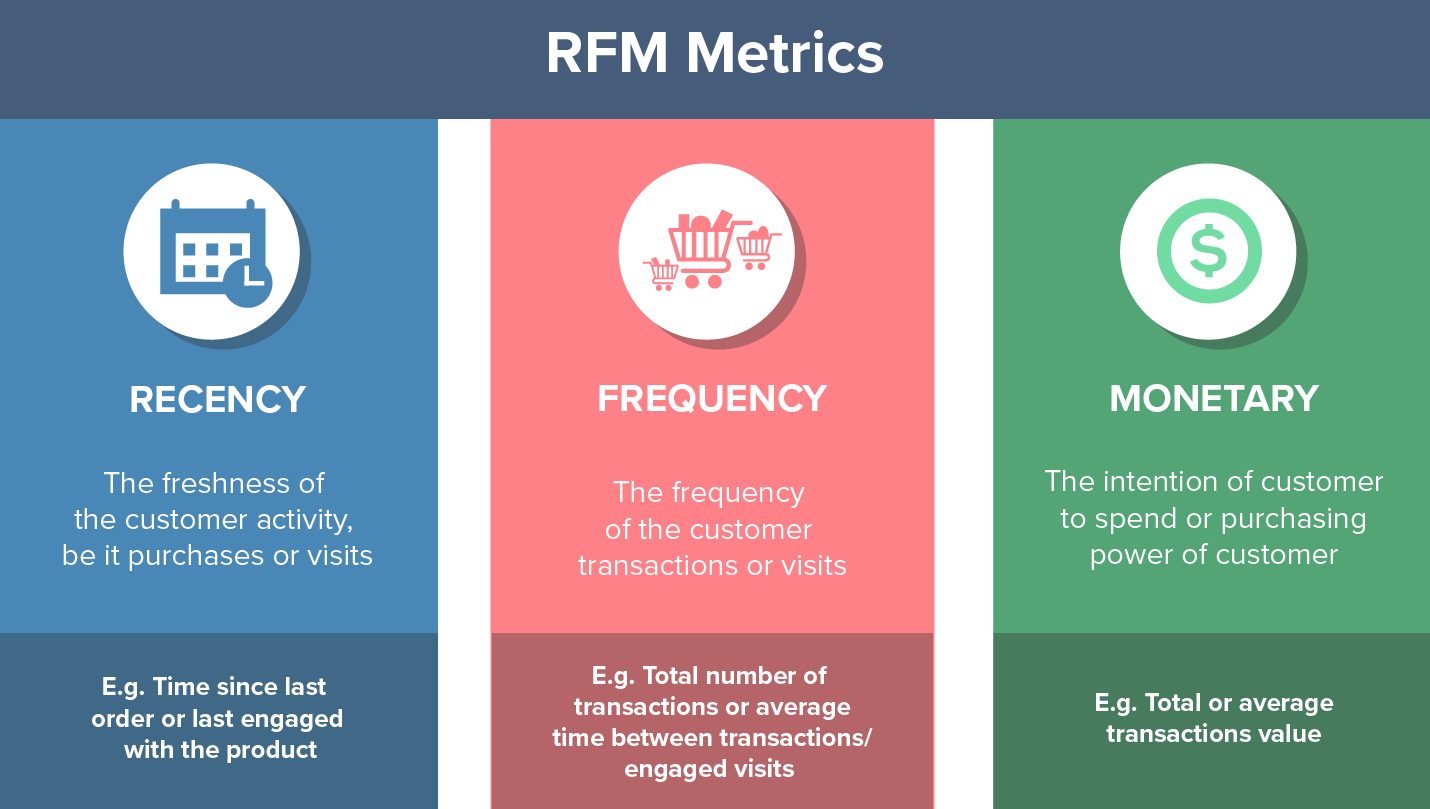

In [23]:
from IPython.display import Image
Image("../input/rfm-metrix/rfm metrics.png")

Before we start with data modelling, we have to group transaction at customer level and calculate their R-F-M metrics.

### Calculating RFM metrics

In [24]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


**1- Recency** - Time since last order or engaged with product.

In [25]:
max_date = max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [26]:
df['time_diff'] = max_date - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,time_diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,373 days 04:24:00


**2-Frequency** - Total number of transactions made by customer or average time between transactions.

In [27]:
rfm_df=df.groupby('CustomerID')[['InvoiceNo']].count()
rfm_df.rename(columns={'InvoiceNo':'frequency'},inplace=True)
rfm_df.head()

,frequency
CustomerID,
12346,2
12347,182
12348,31
12349,73
12350,17


**3-Monetary** - Total or average amount spent by the customer.

In [28]:
rfm_df['Monetary']=df.groupby('CustomerID')[['TotalPrice']].sum()
rfm_df.head()

,frequency,Monetary
CustomerID,,
12346,2,0.00
12347,182,4310.00
12348,31,1797.24
12349,73,1757.55
12350,17,334.40


In [29]:
import datetime as dt

rfm_df['Recency_in_days'] = df.groupby('CustomerID')['time_diff'].min().dt.days
rfm_df = rfm_df.reset_index()
rfm_df.head()

,CustomerID,frequency,Monetary,Recency_in_days
0,12346,2,0.00,325
1,12347,182,4310.00,1
2,12348,31,1797.24,74
3,12349,73,1757.55,18
4,12350,17,334.40,309


### Outliers Treating 

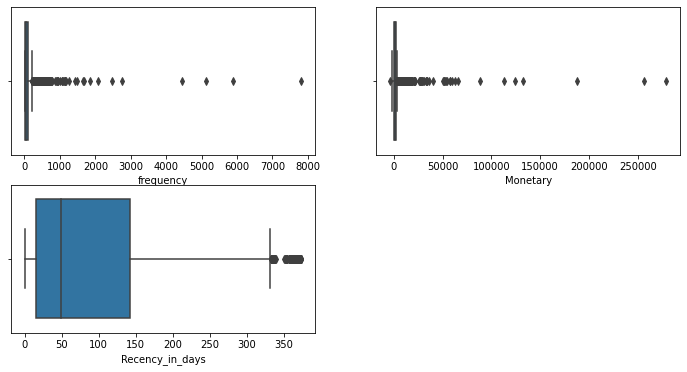

In [30]:
num_features = rfm_df.columns[1:]
r = c = 0
fig,ax = plt.subplots(2,2,figsize=(12,6))

for n,i in enumerate(num_features):
    sns.boxplot(x=i, data=rfm_df,ax=ax[r,c])
    c+=1
    if (n+1)%2==0:
        r+=1
        c=0
ax[r,c].axis("off")
plt.show()

Based on the above box plots, it's visible that Monetary and Frequency attributes have outliers. Since clustering algorithms like K-means are `susceptible` to outliers we will be treating them by capping them at **95%** quantile.

In [31]:
h_cap = 0.95
h_cap_val = rfm_df['Monetary'].quantile(h_cap)
rfm_df['Monetary'][rfm_df['Monetary'] > h_cap_val] = h_cap_val
l_cap = 0.05
l_cap_val = rfm_df['Monetary'].quantile(l_cap)
rfm_df['Monetary'][rfm_df['Monetary'] < l_cap_val] = l_cap_val

In [32]:
cap = 0.95
cap_val = rfm_df['frequency'].quantile(cap)
rfm_df['frequency'][rfm_df['frequency'] > cap_val] = cap_val

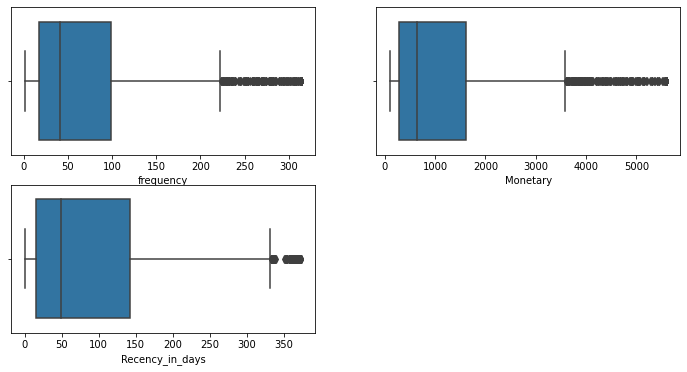

In [33]:
num_features = rfm_df.columns[1:]
r = c = 0
fig,ax = plt.subplots(2,2,figsize=(12,6))

for n,i in enumerate(num_features):
    sns.boxplot(x=i, data=rfm_df,ax=ax[r,c])
    c+=1
    if (n+1)%2==0:
        r+=1
        c=0
ax[r,c].axis("off")
plt.show()

### Creating pipeline for feature scaling & dimensionality reduction

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

preprocessor=Pipeline(
             [
                      ('scalar',MinMaxScaler()),
                      ('pca',PCA(n_components=2, random_state=42))
              ]
                     )

In [44]:
X = rfm_df.drop('CustomerID',axis=1)
X_scaled= pd.DataFrame(preprocessor.fit_transform(X),columns=['PC1','PC2'])
X_scaled

,PC1,PC2
0,-0.571509,0.407006
1,0.671758,0.087523
2,-0.006818,-0.050621
3,0.143697,-0.143446
4,-0.494893,0.399015
...,...,...
4367,-0.486081,0.306485
4368,-0.379219,0.068782
4369,-0.141186,-0.329913
4370,0.680423,0.081729


### Hopkins Test¶


The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

If the value is between {0.01, ...,0.3}, the data is regularly spaced.

If the value is around 0.5, it is random.

If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [41]:
#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [42]:
for i in range(5):
  print('Hopkins statistic value is:',round(hopkins(X_scaled),3))

Hopkins statistic value is: 0.96
Hopkins statistic value is: 0.956
Hopkins statistic value is: 0.957
Hopkins statistic value is: 0.957
Hopkins statistic value is: 0.95


Since the Hopkins test value hovers around 0.95, therefore given data have high clustering tendency.

## 4. Cluster assignment using K-means clustering

#### a) Finding Optimal value of K (Clusters)

**Elbow method**

In [46]:
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X_scaled)
    inertia.append(algorithm.inertia_)

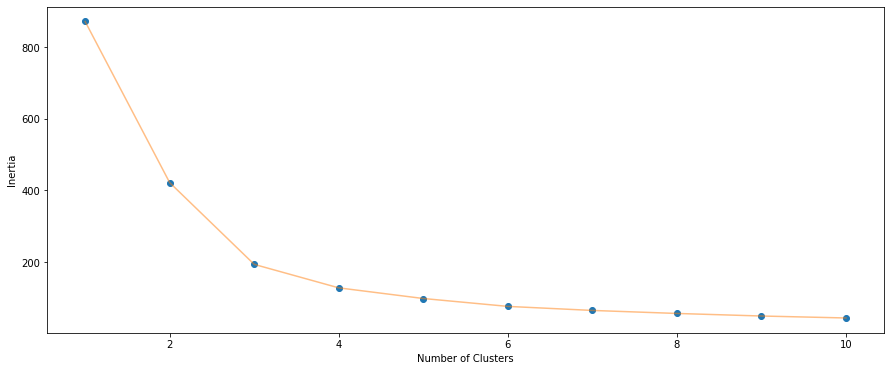

In [47]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

### b) Run K-means using optimal K

In [54]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50,random_state=1)
kmeans.fit(X_scaled)


KMeans(max_iter=50, n_clusters=3, random_state=1)

In [57]:
label = kmeans.fit_predict(X_scaled)
print(label)

[2 1 0 ... 0 1 0]


In [59]:
centroids1 = kmeans.cluster_centers_
centroids1

array([[-0.03733168, -0.15732832],
       [ 0.68010447,  0.15656554],
       [-0.39741231,  0.26942217]])

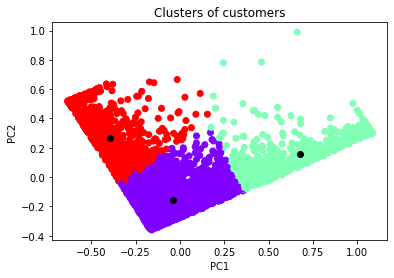

In [65]:
plt.scatter(X_scaled.iloc[:,0],X_scaled.iloc[:,1],c=kmeans.labels_ , cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[: ,1], color='black')
plt.title('Clusters of customers')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

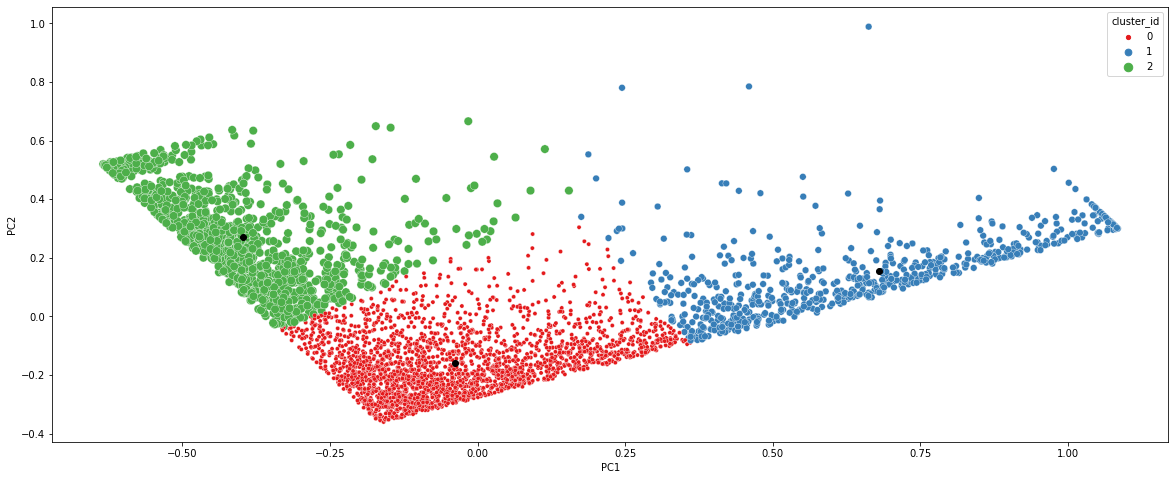

In [72]:
fig = plt.figure(figsize=[20,8])

sns.scatterplot(data=X_scaled,x="PC1",y="PC2",hue="cluster_id",size="cluster_id",palette="Set1")
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[: ,1], color='black')
plt.show()

### c) Clustering profiling using R-F-M

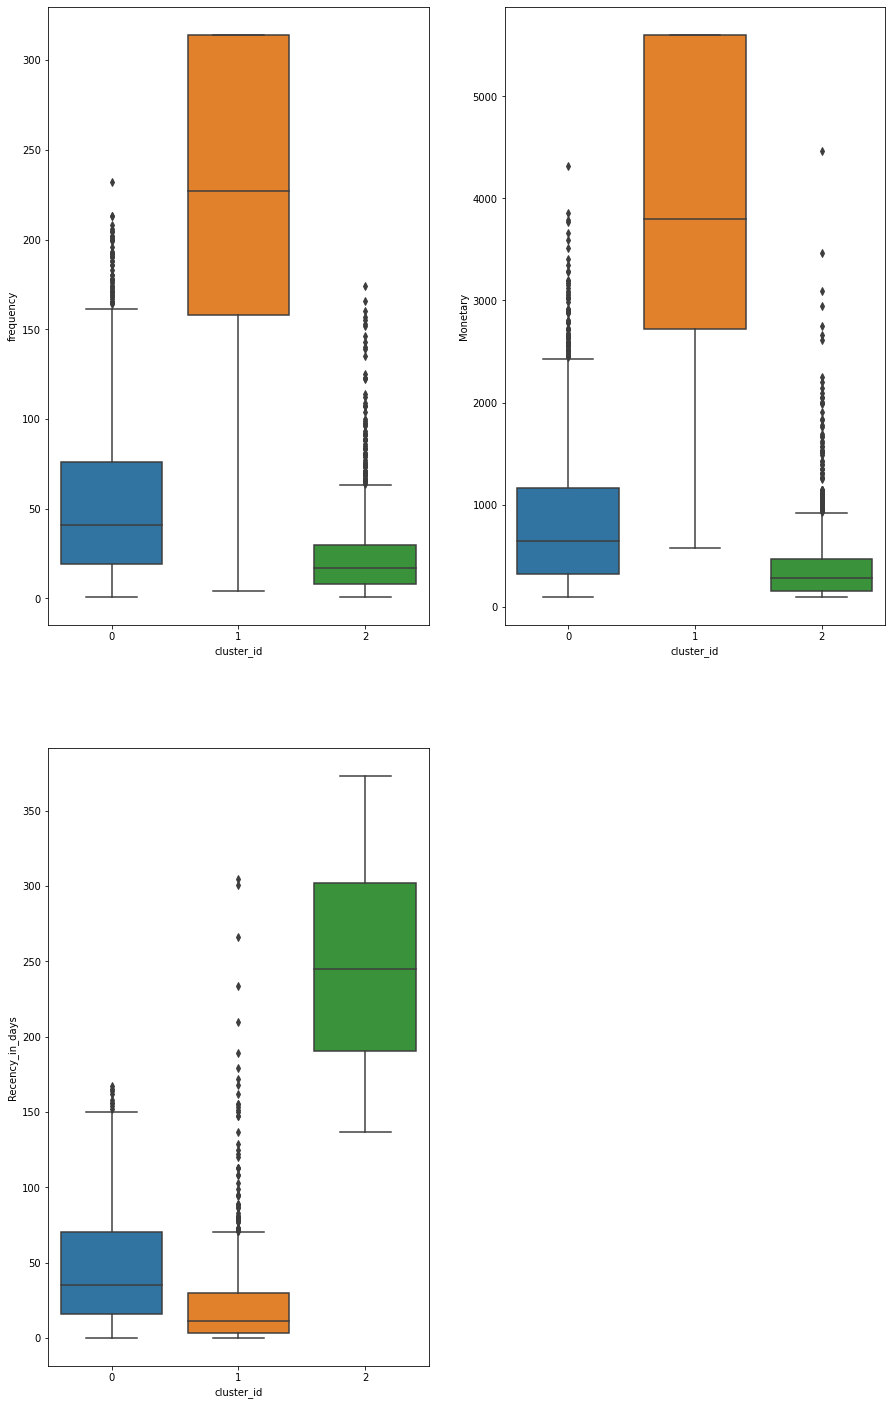

In [73]:
# Visualizing Numerical columns using Boxplots
cols = X.columns[0:-1].tolist()
r = c = 0
fig,ax = plt.subplots(2,2,figsize=(15,25))

for n,i in enumerate(cols):
    sns.boxplot(x='cluster_id',y=cols[n], data=X,ax=ax[r,c])
    c+=1
    if (n+1)%2==0:
        r+=1
        c=0
ax[r,c].axis("off")
plt.show()

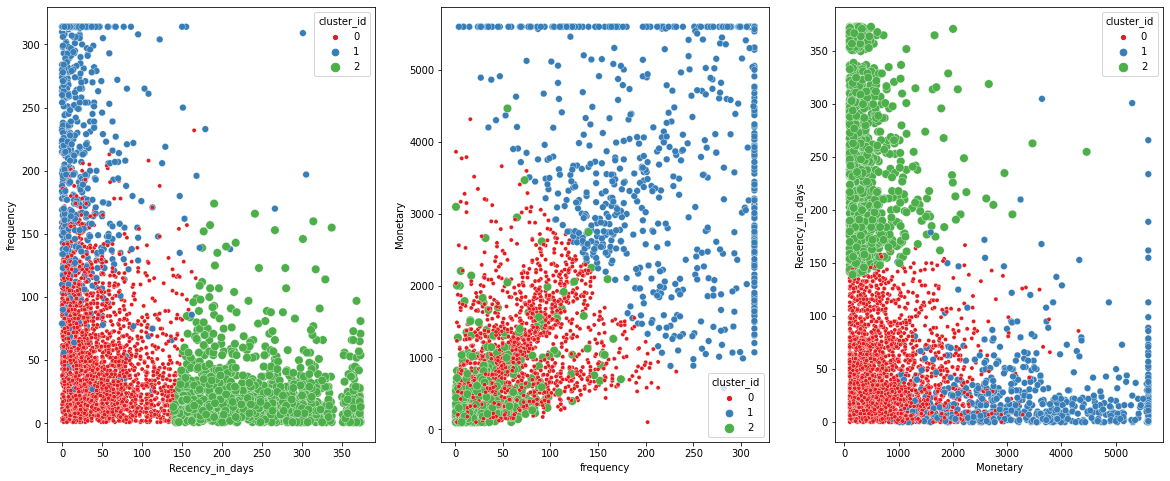

In [77]:
fig = plt.figure(figsize=[20,8])

plt.subplot(1,3,1)
sns.scatterplot(data=X,x="Recency_in_days",y="frequency",hue="cluster_id",size="cluster_id",palette="Set1")
plt.subplot(1,3,2)
sns.scatterplot(data=X,x="frequency",y="Monetary",hue="cluster_id",size="cluster_id",palette="Set1")
plt.subplot(1,3,3)
sns.scatterplot(data=X,x="Monetary",y="Recency_in_days",hue="cluster_id",size="cluster_id",palette="Set1")
plt.show()

In [66]:
# Adding cluster labels to master dataframe
X_scaled['cluster_id'] = kmeans.labels_
X['cluster_id'] = kmeans.labels_

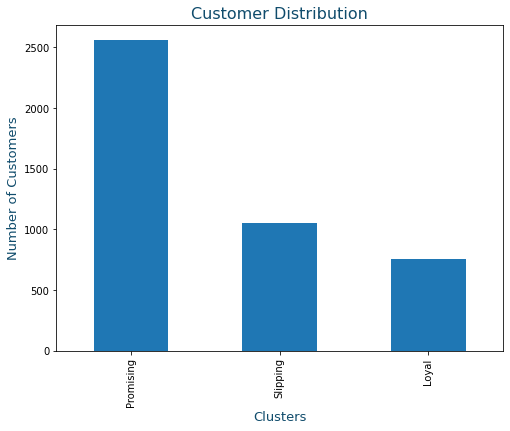

In [68]:
# Number of customers per cluster

font_title = {
        'color':  '#104C6C',
        'weight': 'normal',
        'size': 16,
        }


font_label = {
        'color':  '#104C6C',
        'weight': 'normal',
        'size': 13,
        }
plt.figure(figsize=(8,6))
ax = X_scaled['cluster_id'].value_counts().plot(kind='bar')
ax.set_xticklabels(['Promising','Slipping','Loyal'])
ax.set_ylabel('Number of Customers',font_label)
ax.set_xlabel('Clusters',font_label)
ax.set_title("Customer Distribution",font_title)
plt.show()

**Inference:**

* 1-**Cluster 0** contains the customers who generate the least revenue and are not frequent, most likely because these were one-time customers. Hence they can be labeled as Slipping.
* 2-**Cluster 1** seems to have the most loyal customers, as they bring the most revenue and are often the most frequent customers.
* 3-**Cluster 2** customers seem promising as it consists of frequent buyers, however revenue generation is not as high as Loyal customers.


Cluster Labels:<br>
Cluster 0 - Slipping<br>
Cluster 1 - Loyal<br>
Cluster 2 - Promising

### 5. Recommendations


After segmenting customers into loyal, slipping, and promising it empowers businesses to run personalized, high-performing campaigns and preserves profit margin. Below are a few recommendations or targeted strategies for each customer segment:<br>

**Loyal** - Loyalty programs are effective for these repeat visitors. Advocacy programs and reviews are also common X1X strategies. Lastly, consider rewarding these customers with Free Shipping or other like benefits.

**Promising** - Focus on increasing monetization through product recommendations based on past purchases and incentives tied to spending thresholds.

**Slipping** - Customers leave for a variety of reasons. Depending on your situation price deals, new product launches, or other retention strategies.